In [47]:
import numpy as np
import pandas as pd
import pickle
import gzip

from joblib import Parallel, delayed
import multiprocessing
from index_helpers import load_Kp
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as datetime
import types
import scipy.io
import matplotlib.gridspec as gridspec

import bisect
from scipy import interpolate


from scipy import stats
import xflib
import logging
import math
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2

from mpl_toolkits.axes_grid1 import make_axes_locatable
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')
from scipy.integrate import nquad

from GLD_file_tools import GLD_file_tools


# --------------- Latex Plot Beautification --------------------------
fig_width = 12 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load stencil data:

stencil_fn = '../outputs/stencil_dict_Lshell_power_daynite_updated.pklz'
with gzip.open(stencil_fn, 'rb') as file:
    stencil_dict = pickle.load(file)

In [87]:
# Get Kp data
Ktimes, Kp_arr = load_Kp()
Ktimes = [k + datetime.timedelta(minutes=90) for k in Ktimes]  # 3-hour bins; the original script labeled them in the middle of the bin
Ktimes = np.array(Ktimes)
Kp_arr = np.array(Kp_arr)

# Get Kpmax -- max value of Kp over the last 24 hours (8 bins):
Kpmax = np.max([Kp[0:-8],Kp[1:-7],Kp[2:-6], Kp[3:-5], Kp[4:-4],Kp[5:-3],Kp[6:-2], Kp[7:-1], Kp[8:]],axis=0)
Kpmtimes = Ktimes[8:]

unique_Kpm = np.unique(Kpmax)

[ 0.   0.3  0.7  1.   1.3  1.7  2.   2.3  2.7  3.   3.3  3.7  4.   4.3  4.7
  5.   5.3  5.7  6.   6.3  6.7  7.   7.3  7.7  8.   8.3  8.7  9. ]


In [152]:
stencil_lons = stencil_dict['lons']
inlats = []
inmlts = []
inkps  = []
for k in stencil_dict['data'].keys():
    inlats.append(k[2])
    inmlts.append(k[1])
    inkps.append(k[0])
inlats = np.array(sorted(np.unique(inlats)))
inmlts = np.array(sorted(np.unique(inmlts)))
inkps  = np.array(sorted(np.unique(inkps)))

stencil_Lsh = stencil_dict['Lshells']
stencil_lons = stencil_dict['lons']

# Set up interpolator:
stencil_arr = np.zeros([len(inmlts), len(inlats), len(inkps), len(stencil_Lsh), len(stencil_lons)])

for key in stencil_dict['data'].keys():
    ilat_ind = bisect.bisect_left(inlats, key[2])
    imlt_ind = bisect.bisect_left(inmlts, key[1])
    ikp_ind  = bisect.bisect_left(inkps, key[0])    
    stencil_arr[imlt_ind, ilat_ind, ikp_ind, :, :] = stencil_dict['data'][key]

interp_nite = interpolate.RegularGridInterpolator([inlats, inkps, stencil_Lsh, stencil_lons],
                                                stencil_arr[0], bounds_error=True, fill_value=0)
interp_day = interpolate.RegularGridInterpolator([inlats, inkps, stencil_Lsh, stencil_lons],
                                                stencil_arr[1], bounds_error=True, fill_value=0)

# Set up grid:
gridlons = np.arange(-180, 180, stencil_dict['d_lon'])
gridLs = stencil_dict['Lshells']
pwr_map = np.zeros([len(longrid), len(Lgrid)])


# Precalculate interpolated stencils:
precalc_stencils = dict()
xx, yy = np.meshgrid(stencil_Lsh, stencil_lons)

for kp in np.unique(Kpmax):
    for lat in np.unique(inlats):
        for mlt in np.unique(inmlts):
            key = (int(np.round(10.*kp)), int(lat), int(mlt))
            print key

            
#             pts = [(lat, kp, x[0], x[1]) for x in zip(xx.ravel(), yy.ravel())]
            pts = zip(lat*np.ones_like(xx.ravel()),
                      kp*np.ones_like(xx.ravel()), 
                      xx.ravel(), 
                      yy.ravel())
            if (mlt == inmlts[0]):
                tmp = interp_nite(pts).reshape(len(stencil_lons), len(stencil_Lsh))
            elif (mlt == inmlts[1]):
                tmp = interp_day(pts).reshape(len(stencil_lons), len(stencil_Lsh))
            
            precalc_stencils[key] = tmp
            
#             plt.figure()
#             plt.imshow(tmp, origin='lower')

(0, 15, 0)
(0, 15, 12)
(0, 16, 0)
(0, 16, 12)
(0, 17, 0)
(0, 17, 12)
(0, 18, 0)
(0, 18, 12)
(0, 19, 0)
(0, 19, 12)
(0, 20, 0)
(0, 20, 12)
(0, 21, 0)
(0, 21, 12)
(0, 22, 0)
(0, 22, 12)
(0, 23, 0)
(0, 23, 12)
(0, 24, 0)
(0, 24, 12)
(0, 25, 0)
(0, 25, 12)
(0, 26, 0)
(0, 26, 12)
(0, 27, 0)
(0, 27, 12)
(0, 28, 0)
(0, 28, 12)
(0, 29, 0)
(0, 29, 12)
(0, 30, 0)
(0, 30, 12)
(0, 31, 0)
(0, 31, 12)
(0, 32, 0)
(0, 32, 12)
(0, 33, 0)
(0, 33, 12)
(0, 34, 0)
(0, 34, 12)
(0, 35, 0)
(0, 35, 12)
(0, 36, 0)
(0, 36, 12)
(0, 37, 0)
(0, 37, 12)
(0, 38, 0)
(0, 38, 12)
(0, 39, 0)
(0, 39, 12)
(0, 40, 0)
(0, 40, 12)
(0, 41, 0)
(0, 41, 12)
(0, 42, 0)
(0, 42, 12)
(0, 43, 0)
(0, 43, 12)
(0, 44, 0)
(0, 44, 12)
(0, 45, 0)
(0, 45, 12)
(0, 46, 0)
(0, 46, 12)
(0, 47, 0)
(0, 47, 12)
(0, 48, 0)
(0, 48, 12)
(0, 49, 0)
(0, 49, 12)
(0, 50, 0)
(0, 50, 12)
(0, 51, 0)
(0, 51, 12)
(0, 52, 0)
(0, 52, 12)
(0, 53, 0)
(0, 53, 12)
(0, 54, 0)
(0, 54, 12)
(3, 15, 0)
(3, 15, 12)
(3, 16, 0)
(3, 16, 12)
(3, 17, 0)
(3, 17, 12)
(3, 18, 0)


ValueError: One of the requested xi is out of bounds in dimension 1

In [443]:
data_path = '../outputs/GLDstats_v6/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
period_factor = stencil_duration/file_duration

# Separate maps for dayside and nightside contributions
pwr_maps = dict()
# for mlt in inmlts:
#     pwr_maps[mlt] = np.zeros([len(longrid), len(Lgrid)])


total_files = len(files)

cur_map_total = np.zeros([180, 360])
count=0
counts = dict()

for f_ind, filename in enumerate(files):
    print "loading %d/%d"%(f_ind, total_files)
    with gzip.open(os.path.join(data_path, filename)) as f:
        thingy = pickle.load(f)
        intime = datetime.datetime.strptime(filename[:-5],'%m_%d_%Y_%H_%M')
#         print thingy.keys()
        # Get current Kpmax
        Kpm_index = bisect.bisect_left(Kpmtimes, intime)
        Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp
        print Kpm
        # Load squared current map:
        cur_map = thingy['cur_map']
        
        # Select day and night bins:
        mltvec = xf.lon2MLT(intime, gridlons)
        mltvec_quantized = np.zeros_like(gridlons)
        mltvec_quantized[(mltvec > 6) & (mltvec <= 18)] = 12
          
#         mltvec_quantized = np.digitize(mltvec, [0, 6, 18, 24])
#         print mltvec_quantized
#         plt.figure()
#         plt.plot(gridlons, mltvec_quantized)
        cur_map_total += cur_map
        # Loop through each cell in the input current map, interpolate and add
        todo = np.where(cur_map > 0)
        
        
        outkey = int(np.round(10.*Kpm))        
        if counts.has_key(outkey):
            counts[outkey] += 1
        else:
            counts[outkey] = 1
        for x,y in zip(todo[0], todo[1]):
            I = cur_map[x,y] # squared input current
            # Absolute value on latitude, since we're assuming model is symmetric North / South
            cur_mlt = int(mltvec_quantized[y])
            cur_lat = int(np.abs(np.round(gridlats[x])))
            key = (int(np.round(10.*Kpm)), cur_lat, cur_mlt)
#             key = (0, cur_lat, cur_mlt)
    
            # this version to track activity at each Kp
            outkey = (cur_mlt, int(np.round(10.*Kpm)))
            
#             # this version to just do average day + night
#             outkey = cur_mlt
            
            if precalc_stencils.has_key(key):
                stencil = precalc_stencils[key]*I

                # Add to respective map:
                lonleft  = int(y*4 - len(stencil_lons)/2 - 1)
                lonright = int(y*4 + len(stencil_lons)/2)
                
                if not pwr_maps.has_key(outkey):
                    pwr_maps[outkey] = np.zeros([len(longrid), len(Lgrid)])
                if lonleft < 0:
                    # wrap left
                    pwr_maps[outkey][0:lonright,: ]+= stencil[np.abs(lonleft):,:]
                    pwr_maps[outkey][(len(gridlons) - np.abs(lonleft)):,:] += \
                            stencil[0:np.abs(lonleft),:]

                elif lonright >= len(gridlons):
                    # wrap right
                    pwr_maps[outkey][lonleft:len(gridlons),:] += stencil[0:len(gridlons) - lonleft, :]
                    pwr_maps[outkey][0:np.abs(lonright) - len(gridlons), :] += stencil[len(gridlons) - lonleft,:]

                else:
                    # Middle
                    pwr_maps[outkey][lonleft:lonright, :] += stencil

# ax[0].imshow(np.log10(pwr_maps[0]).T, origin='lower', interpolation='none')

pwr_maps_linear = dict()

for k in pwr_maps.keys():
#     pwr_maps[k] *= period_factor/(f_ind + 1.)
    pwr_maps[k] *= period_factor/counts[k[1]]
    pwr_maps_linear[k] = pwr_maps[k]
    pwr_maps[k] = np.log10(pwr_maps[k])
    pwr_maps[k][np.isinf(pwr_maps[k])] = -100
    

loading 0/3157
2.7
loading 1/3157
1.0
loading 2/3157
2.7
loading 3/3157
3.0
loading 4/3157
3.3
loading 5/3157
2.3
loading 6/3157
3.3
loading 7/3157
2.0
loading 8/3157
3.0
loading 9/3157
3.7
loading 10/3157
2.3
loading 11/3157
1.7
loading 12/3157
2.7
loading 13/3157
6.3
loading 14/3157
3.7
loading 15/3157
3.0
loading 16/3157
3.0
loading 17/3157
4.0
loading 18/3157
5.3
loading 19/3157
3.0
loading 20/3157
6.0
loading 21/3157
3.7
loading 22/3157
3.7
loading 23/3157
4.3
loading 24/3157
3.0
loading 25/3157
5.0
loading 26/3157
3.0
loading 27/3157
3.7
loading 28/3157
3.7
loading 29/3157
3.0
loading 30/3157
6.3
loading 31/3157
2.7
loading 32/3157
2.3
loading 33/3157
4.0
loading 34/3157
4.0
loading 35/3157
2.7
loading 36/3157
2.3
loading 37/3157
6.0
loading 38/3157
5.3
loading 39/3157
4.0
loading 40/3157
3.7
loading 41/3157
1.7
loading 42/3157
3.7
loading 43/3157
3.3
loading 44/3157
2.0
loading 45/3157
3.7
loading 46/3157
2.7
loading 47/3157
0.3
loading 48/3157
2.0
loading 49/3157
3.3
loading 50

<IPython.core.display.Javascript object>


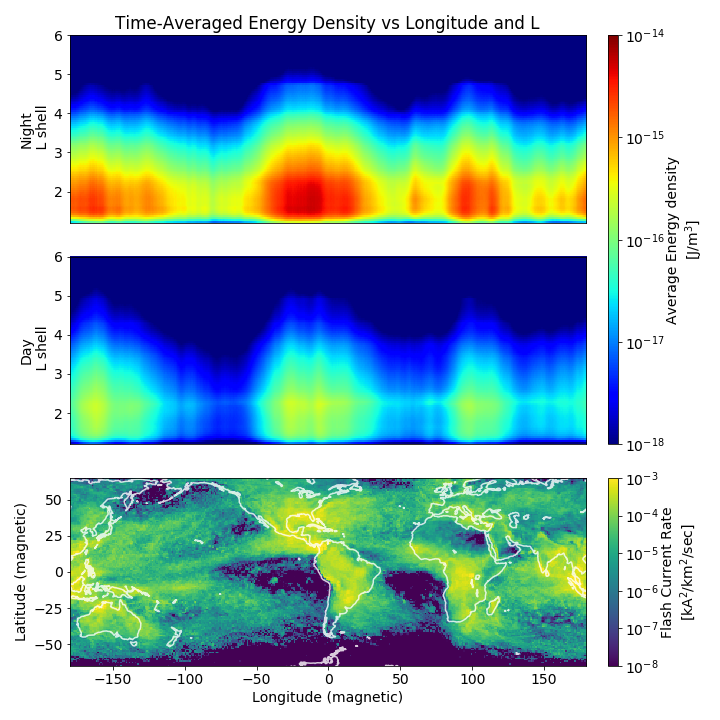

-100.0 -2.56412891224


In [431]:
# Area of each cell, in km: 
R_E = 6371. # Km
R2D = 180./np.pi
D2R = np.pi/180.
dlon = 1
dlat = 1
sec_in_year = 60*60*24*365.25
cell_areas = np.abs((R_E*dlat*D2R)*(R_E*dlon*D2R)*np.cos((np.abs(gridlats) + dlat/2.0)*D2R))

# Load coastlines (for plotting)
with gzip.open('../../Thesis figures/python_local/mag_coastlines.gzip','rb') as file:
    coast = pickle.load(file)

# --------------- Latex Plot Beautification --------------------------
fig_width = 9 
fig_height = 9
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

# fig, ax = plt.subplots(3,1)
clims = [-18, -14]


fig = plt.figure()
gs = gridspec.GridSpec(3,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
ax.append(plt.subplot(gs[2,0]))
cax = plt.subplot(gs[0:2,1])
cax2= plt.subplot(gs[2,1])
p0 = ax[0].pcolorfast(gridlons - 180, gridLs, pwr_maps[0].T,  cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
p1 = ax[1].pcolorfast(gridlons - 180, gridLs, pwr_maps[12].T, cmap = plt.get_cmap('jet'),
                      vmin=clims[0], vmax=clims[1])
ax[0].set_ylim([1.2, 6])
ax[1].set_ylim([1.2, 6])

# Colorbar
cb = plt.colorbar(p0, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Average Energy density\n[J/m$^3$]') 


cmt = cur_map_total/(f_ind + 1)
cmt /= file_duration
# cmt *= sec_in_year
cmt /= (1000.*1000)
cmt /= cell_areas[:,np.newaxis]
cmt = np.log10(cmt)
cmt[np.isinf(cmt)] = -100

clims2 = [-8, -3]
print np.min(cmt), np.max(cmt)
p3 = ax[2].pcolorfast(np.arange(-180,180), np.arange(-90, 90), cmt, vmin=clims2[0], vmax=clims2[1],
                      cmap = plt.get_cmap('viridis'))
ax[2].plot(coast['lon'], coast['lat'], color='w', alpha=0.8)
ax[2].set_xlim([-180, 179])
ax[2].set_ylim([-65, 65])
# ax[2].set_aspect('equal')

# Colorbar
cb2 = plt.colorbar(p3, cax=cax2)
cticks = np.arange(clims2[0],clims2[1] + 1)
cb2.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb2.set_ticklabels(cticklabels)
cb2.set_label('Flash Current Rate\n[kA$^2$/km$^2$/sec]') 


ax[0].set_xticks([])
ax[0].set_ylabel('Night\n L shell')
ax[1].set_ylabel('Day\n L shell')
ax[1].set_xticks([])
ax[2].set_xlabel('Longitude (magnetic)')
ax[2].set_ylabel('Latitude (magnetic)')

ax[0].set_title('Time-Averaged Energy Density vs Longitude and L')
gs.tight_layout(fig)

fig.savefig('Energy_density_daynite.png',dpi=300)

520 760
[-13.10291991  -0.93390754]


<IPython.core.display.Javascript object>


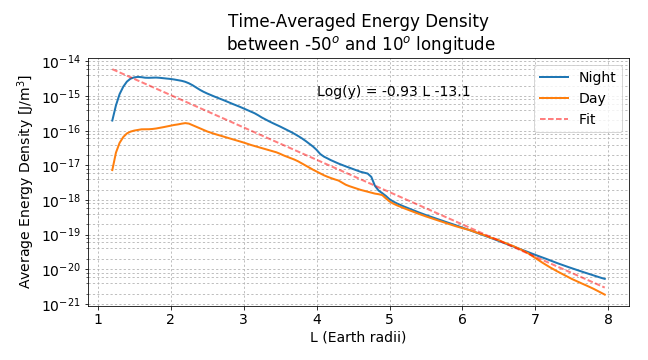

In [429]:
import scipy.optimize

# Line plot of day + night trends over the US:
# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


dens_vs_L = dict()

lonlims = [-50, 10]  # ~ approximately over the US

left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

print left_ind, right_ind

for k in pwr_maps.keys():
    dens_vs_L[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind, :], axis=0)/(right_ind - left_ind)
    

def func(x, a, b):
    return a + b*x
popt, pcov = scipy.optimize.curve_fit(func, gridLs, np.log10((dens_vs_L[0] + dens_vs_L[12])/2.))

print popt

fit = func(gridLs, popt[0], popt[1])
fig, ax = plt.subplots(1,1)
ax.semilogy(gridLs, dens_vs_L[0], linewidth=2, label='Night')
ax.semilogy(gridLs, dens_vs_L[12], linewidth=2, label='Day')
ax.semilogy(gridLs, pow(10,fit), '--',linewidth=2, label='Fit', alpha=0.5, color='r')
# ax.set_ylim([-18, -14])
ax.grid('on', which='both', linestyle=':')
ax.legend()

ax.text(4, 1e-15, "Log(y) = %2.2f L %2.1f"%(popt[1], popt[0]))
ax.set_xlabel('L (Earth radii)')
ax.set_ylabel('Average Energy Density [J/m$^3$]')
ax.set_title('Time-Averaged Energy Density\n between %d$^o$ and %d$^o$ longitude'%(lonlims[0], lonlims[1]))
fig.tight_layout()
fig.savefig('density_vs_L.png',dpi=300)

In [384]:
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
# ydata = y + 0.2 * np.random.normal(size=len(xdata))
popt, pcov = scipy.optimize.curve_fit(func, gridLs, de)


(30, 30, 0) True
(159, 136)
(1440, 136)
x,y: 120 1400
(1440,)
(159,)
1321 1480

2.92272491928e-18


<IPython.core.display.Javascript object>


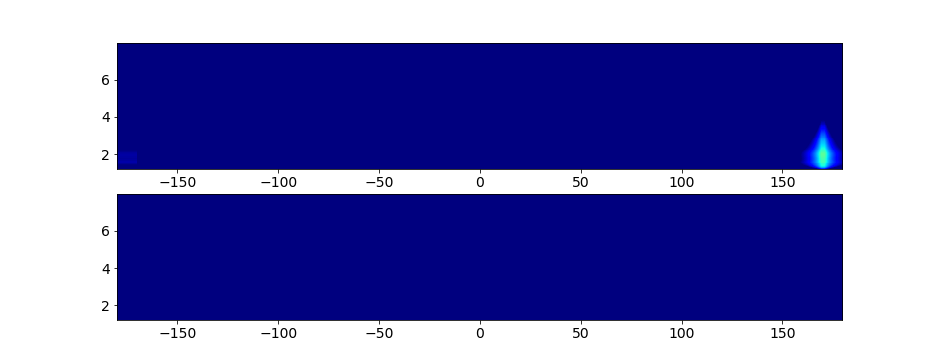

In [218]:

pwr_maps = dict()
for mlt in inmlts:
    pwr_maps[mlt] = np.zeros([len(longrid), len(Lgrid)])



x = 120 # latitude index
y = 1400 # longitude index


I = 10000 # cur_map[x,y] # squared input current
# Absolute value on latitude, since we're assuming model is symmetric North / South
cur_mlt = int(mltvec_quantized[y])
cur_lat = int(np.abs(np.round(gridlats[x])))
key = (int(np.round(10.*Kpm)), cur_lat, cur_mlt)
print key, precalc_stencils.has_key(key)
if precalc_stencils.has_key(key):
    stencil = precalc_stencils[key]*I
    print np.shape(stencil)
    print np.shape(pwr_maps[cur_mlt])
    # Add to respective map:
    lonleft  = int(y - len(stencil_lons)/2)
    lonright = int(y + len(stencil_lons)/2 + 1)
    print "x,y:", x, y
    print np.shape(gridlons)
    print np.shape(stencil_lons)
    print lonleft, lonright
    print 
    print np.sum(stencil)
    
    if lonleft < 0:
        # wrap left
        pwr_maps[cur_mlt][0:lonright,: ]+= stencil[np.abs(lonleft):,:]
        pwr_maps[cur_mlt][(len(gridlons) - np.abs(lonleft)):,:] += \
                stencil[0:np.abs(lonleft),:]
        
    elif lonright >= len(gridlons):
        # wrap right
        pwr_maps[cur_mlt][lonleft:len(gridlons),:] += stencil[0:len(gridlons) - lonleft, :]
        pwr_maps[cur_mlt][0:np.abs(lonright) - len(gridlons), :] += stencil[len(gridlons) - lonleft,:]

    else:
        # Middle
        pwr_maps[cur_mlt][lonleft:lonright, :] += stencil
    

else:
    print "no key"
    
fig, ax = plt.subplots(2,1)
clims = [-22, -18]
for k in pwr_maps.keys():
    pwr_maps[k] = np.log10(pwr_maps[k])
    pwr_maps[k][np.isinf(pwr_maps[k])] = -100
ax[0].pcolorfast(gridlons, gridLs, pwr_maps[0].T,  cmap = plt.get_cmap('jet'), vmin=clims[0], vmax=clims[1])
ax[1].pcolorfast(gridlons, gridLs, pwr_maps[12].T, cmap = plt.get_cmap('jet'), vmin=clims[0], vmax=clims[1])



In [2]:
data_path = '../outputs/GLDstats_v6/data/'

flash_map = np.zeros([180,360])
cur_map   = np.zeros([180,360])
pwr_map   = np.zeros([180,360])
mlt_hist  = np.zeros(48)

gridlats = np.arange(-90, 90, 1)
gridlons = np.arange(-180,180,1)

lookback_time = datetime.timedelta(hours=3)

d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]

total_files = len(files)
count=0
for f_ind, filename in enumerate(files):
    print "loading %d/%d"%(f_ind, total_files)
    with gzip.open(os.path.join(data_path, filename)) as f:
        thingy = pickle.load(f)
        flash_map += thingy['flash_map']
        cur_map   += thingy['cur_map']
        pwr_map   += thingy['pwr_map']
        mlt_hist  += thingy['mlt_hist']

flash_map /= 1.0*len(files)
cur_map  /= 1.0*len(files)
pwr_map /= 1.0*len(files)


loading 0/3157
loading 1/3157
loading 2/3157
loading 3/3157
loading 4/3157
loading 5/3157
loading 6/3157
loading 7/3157
loading 8/3157
loading 9/3157
loading 10/3157
loading 11/3157
loading 12/3157
loading 13/3157
loading 14/3157
loading 15/3157
loading 16/3157
loading 17/3157
loading 18/3157
loading 19/3157
loading 20/3157
loading 21/3157
loading 22/3157
loading 23/3157
loading 24/3157
loading 25/3157
loading 26/3157
loading 27/3157
loading 28/3157
loading 29/3157
loading 30/3157
loading 31/3157
loading 32/3157
loading 33/3157
loading 34/3157
loading 35/3157
loading 36/3157
loading 37/3157
loading 38/3157
loading 39/3157
loading 40/3157
loading 41/3157
loading 42/3157
loading 43/3157
loading 44/3157
loading 45/3157
loading 46/3157
loading 47/3157
loading 48/3157
loading 49/3157
loading 50/3157
loading 51/3157
loading 52/3157
loading 53/3157
loading 54/3157
loading 55/3157
loading 56/3157
loading 57/3157
loading 58/3157
loading 59/3157
loading 60/3157
loading 61/3157
loading 62/3157
lo

520 760


<IPython.core.display.Javascript object>


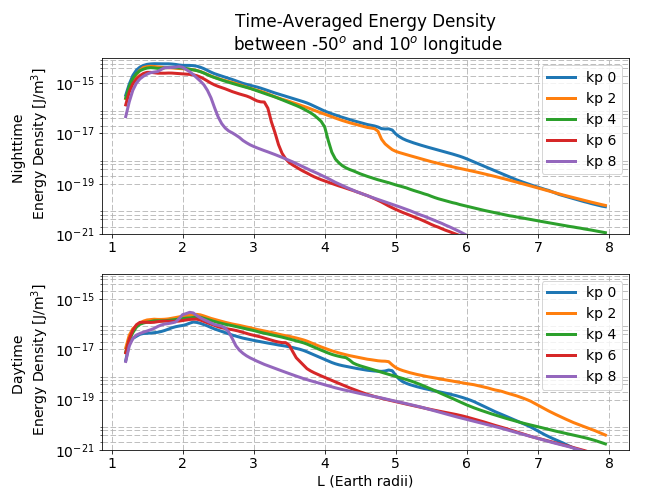

In [507]:
import scipy.optimize

# Line plot of day + night trends over the US:
# --------------- Latex Plot Beautification --------------------------
fig_width = 8 
fig_height = 6
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


dens_vs_L = dict()

lonlims = [-50, 10]  # ~ approximately over the US

left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

print left_ind, right_ind

for k in pwr_maps.keys():
    dens_vs_L[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind, :], axis=0)/(right_ind - left_ind)

fig, ax = plt.subplots(2,1)
# ax[0].set_facecolor('grey')
# ax[1].set_facecolor('grey')



# for k in dens_vs_L.keys():

cm = plt.get_cmap('Vega10')
for ind, kp in enumerate([3, 20, 40, 60, 80]):
    color = cm(ind)
    ax[0].semilogy(gridLs, dens_vs_L[(0,  kp)], linewidth=3, label = 'kp %d'%int(np.floor(kp/10)), color=color)
    ax[1].semilogy(gridLs, dens_vs_L[(12, kp)], linewidth=3, label = 'kp %d'%int(np.floor(kp/10)), color=color)


# ax.set_ylim([-18, -14])
ax[0].grid('on', which='both', linestyle='--')
ax[1].grid('on', which='both', linestyle='--')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim([1e-21, 1e-14])
ax[1].set_ylim([1e-21, 1e-14])
ax[1].set_xlabel('L (Earth radii)')
ax[0].set_ylabel('Nighttime \n Energy Density [J/m$^3$]')
ax[1].set_ylabel('Daytime \n Energy Density [J/m$^3$]')
ax[0].set_title('Time-Averaged Energy Density\n between %d$^o$ and %d$^o$ longitude'%(lonlims[0], lonlims[1]))


fig.tight_layout()
fig.savefig('density_vs_L_multiple_kp.png',dpi=300)

In [451]:
print np.unique(Kpmax)

[ 0.   0.3  0.7  1.   1.3  1.7  2.   2.3  2.7  3.   3.3  3.7  4.   4.3  4.7
  5.   5.3  5.7  6.   6.3  6.7  7.   7.3  7.7  8.   8.3  8.7  9. ]


# Now do it again for spectral content

In [519]:
# Load stencil data:

# (big file to load)
stencil_fn = '../outputs/stencil_dict_Lshell_power_daynite_with_spectrum.pkl'
with open(stencil_fn, 'rb') as file:
    stencil_dict = pickle.load(file)

In [524]:
stencil_lons = stencil_dict['lons']
stencil_freqs = np.sum(np.array(stencil_dict['freq_pairs']), axis=1)/2.  # Center freqs of each bin

inlats = []
inmlts = []
inkps  = []
for k in stencil_dict['data'].keys():
    inlats.append(k[2])
    inmlts.append(k[1])
    inkps.append(k[0])
inlats = np.array(sorted(np.unique(inlats)))
inmlts = np.array(sorted(np.unique(inmlts)))
inkps  = np.array(sorted(np.unique(inkps)))

stencil_Lsh = stencil_dict['Lshells']
stencil_lons = stencil_dict['lons']

# Set up interpolator:
stencil_arr = np.zeros([len(inmlts), len(inlats), len(inkps), len(stencil_Lsh), len(stencil_freqs), len(stencil_lons)])

for key in stencil_dict['data'].keys():
    ilat_ind = bisect.bisect_left(inlats, key[2])
    imlt_ind = bisect.bisect_left(inmlts, key[1])
    ikp_ind  = bisect.bisect_left(inkps, key[0])    
    stencil_arr[imlt_ind, ilat_ind, ikp_ind, :, :, :] = stencil_dict['data'][key]

In [636]:
interp_nite = interpolate.RegularGridInterpolator([inlats, inkps, stencil_Lsh, stencil_freqs, stencil_lons],
                                                stencil_arr[0], bounds_error=True, fill_value=0)
interp_day = interpolate.RegularGridInterpolator([inlats, inkps, stencil_Lsh, stencil_freqs, stencil_lons],
                                                stencil_arr[1], bounds_error=True, fill_value=0)

stencil_lons_reduced = np.linspace(-19, 19, 2*19+1)
print stencil_lons_reduced
# Set up grid:
# gridlons = np.arange(-180, 180, stencil_dict['d_lon'])
gridlons = np.arange(-180, 180, 1)
gridLs = stencil_dict['Lshells']
gridFs = np.linspace(stencil_freqs[0], stencil_freqs[-1], 100) #stencil_freqs
pwr_map = np.zeros([len(longrid), len(Lgrid)])


# Precalculate interpolated stencils:
precalc_stencils = dict()
xx, yy, zz = np.meshgrid(gridLs, gridFs, stencil_lons_reduced, indexing='ij')
total_jobs = len(np.unique(Kpmax))*len(np.unique(inlats))*len(np.unique(inmlts))
cur_job = 1
for kp in np.unique(Kpmax):
    for lat in np.unique(inlats):
        for mlt in np.unique(inmlts):
            key = (int(np.round(10.*kp)), int(lat), int(mlt))
            print key
            print "%d/%d"%(cur_job, total_jobs)
            cur_job += 1
#             pts = [(lat, kp, x[0], x[1]) for x in zip(xx.ravel(), yy.ravel())]
            pts = zip(lat*np.ones_like(xx.ravel()),
                      kp*np.ones_like(xx.ravel()), 
                      xx.ravel(), 
                      yy.ravel(),
                      zz.ravel())
            if (mlt == inmlts[0]):
                tmp = interp_nite(pts).reshape(len(gridLs), len(gridFs), len(stencil_lons_reduced))
            elif (mlt == inmlts[1]):
                tmp = interp_day(pts).reshape(len(gridLs), len(gridFs), len(stencil_lons_reduced))
            
            precalc_stencils[key] = tmp
            
#             plt.figure()
#             plt.imshow(tmp[:,0,:], origin='lower')
            
            

[-19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.
  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.
  11.  12.  13.  14.  15.  16.  17.  18.  19.]
(0, 15, 0)
1/2240
(0, 15, 12)
2/2240
(0, 16, 0)
3/2240
(0, 16, 12)
4/2240
(0, 17, 0)
5/2240
(0, 17, 12)
6/2240
(0, 18, 0)
7/2240
(0, 18, 12)
8/2240
(0, 19, 0)
9/2240
(0, 19, 12)
10/2240
(0, 20, 0)
11/2240
(0, 20, 12)
12/2240
(0, 21, 0)
13/2240
(0, 21, 12)
14/2240
(0, 22, 0)
15/2240
(0, 22, 12)
16/2240
(0, 23, 0)
17/2240
(0, 23, 12)
18/2240
(0, 24, 0)
19/2240
(0, 24, 12)
20/2240
(0, 25, 0)
21/2240
(0, 25, 12)
22/2240
(0, 26, 0)
23/2240
(0, 26, 12)
24/2240
(0, 27, 0)
25/2240
(0, 27, 12)
26/2240
(0, 28, 0)
27/2240
(0, 28, 12)
28/2240
(0, 29, 0)
29/2240
(0, 29, 12)
30/2240
(0, 30, 0)
31/2240
(0, 30, 12)
32/2240
(0, 31, 0)
33/2240
(0, 31, 12)
34/2240
(0, 32, 0)
35/2240
(0, 32, 12)
36/2240
(0, 33, 0)
37/2240
(0, 33, 12)
38/2240
(0, 34, 0)
39/2240
(0, 34, 12)
40/2240
(0, 35, 0)
41/2240
(0, 35, 12)

ValueError: One of the requested xi is out of bounds in dimension 1

In [655]:
data_path = '../outputs/GLDstats_v6/data/'
d = os.listdir(data_path)
files = [x for x in d if x.endswith('.pklz')]
intimes = [datetime.datetime.strptime(x[:-5],'%m_%d_%Y_%H_%M') for x in d if x.endswith('.pklz')]


gridlons = np.linspace(-180, 179, 360)
# print gridlons
stencil_duration = 20. # seconds
file_duration = 3*3600. # 3 hours in seconds
period_factor = stencil_duration/file_duration

# Separate maps for dayside and nightside contributions
pwr_maps = dict()
# for mlt in inmlts:
#     pwr_maps[mlt] = np.zeros([len(longrid), len(Lgrid)])


total_files = len(files)

cur_map_total = np.zeros([180, 360])
count=0
counts = dict()

for f_ind, filename in enumerate(files):
    print "loading %d/%d"%(f_ind, total_files)
    with gzip.open(os.path.join(data_path, filename)) as f:
        thingy = pickle.load(f)
        intime = datetime.datetime.strptime(filename[:-5],'%m_%d_%Y_%H_%M')
#         print thingy.keys()
        # Get current Kpmax
        Kpm_index = bisect.bisect_left(Kpmtimes, intime)
        Kpm = min(8,Kpmax[Kpm_index])  # Interpolation is only good up to kp
        print Kpm
        # Load squared current map:
        cur_map = thingy['cur_map']
        
        # Select day and night bins:
        mltvec = xf.lon2MLT(intime, gridlons)
        mltvec_quantized = np.zeros_like(gridlons)
        mltvec_quantized[(mltvec > 6) & (mltvec <= 18)] = 12
          
#         mltvec_quantized = np.digitize(mltvec, [0, 6, 18, 24])
#         print mltvec_quantized
#         plt.figure()
#         plt.plot(gridlons, mltvec_quantized)
        cur_map_total += cur_map
        # Loop through each cell in the input current map, interpolate and add
        todo = np.where(cur_map > 0)
        
        
#         outkey = int(np.round(10.*Kpm))        
        outkey = cur_mlt

        if counts.has_key(outkey):
            counts[outkey] += 1
        else:
            counts[outkey] = 1
        for x,y in zip(todo[0], todo[1]):
            I = cur_map[x,y] # squared input current
            # Absolute value on latitude, since we're assuming model is symmetric North / South
            cur_mlt = int(mltvec_quantized[y])
            cur_lat = int(np.abs(np.round(gridlats[x])))
            key = (int(np.round(10.*Kpm)), cur_lat, cur_mlt)
            key = (0, cur_lat, cur_mlt)
    
            # this version to track activity at each Kp
#             outkey = (cur_mlt, int(np.round(10.*Kpm)))
            
#             # this version to just do average day + night
            outkey = cur_mlt
            
            if precalc_stencils.has_key(key):
                stencil = precalc_stencils[key].swapaxes(0,2)*I
#                 print "sten is", np.shape(stencil)

                # Add to respective map:
                lonleft  = int(y - len(stencil_lons_reduced)/2 - 1)
                lonright = int(y + len(stencil_lons_reduced)/2)
                
                if not pwr_maps.has_key(outkey):
                    pwr_maps[outkey] = np.zeros([len(gridlons), len(gridFs), len(gridLs)])
#                     print "pwr map is", np.shape(pwr_maps[outkey])
                if lonleft < 0:
                    # wrap left
                    pwr_maps[outkey][0:lonright,:,: ]+= stencil[np.abs(lonleft):,:,:]
                    pwr_maps[outkey][(len(gridlons) - np.abs(lonleft)):,:] += \
                            stencil[0:np.abs(lonleft),:]

                elif lonright > len(gridlons):
                    # wrap right
                    pwr_maps[outkey][lonleft:len(gridlons),:,:] += stencil[0:len(gridlons) - lonleft,:, :]
                    pwr_maps[outkey][0:np.abs(lonright) - len(gridlons),:, :] += stencil[len(gridlons) - lonleft,:,:]

                else:
                    # Middle
                    pwr_maps[outkey][lonleft:lonright, :, :] += stencil

# ax[0].imshow(np.log10(pwr_maps[0]).T, origin='lower', interpolation='none')

pwr_maps_linear = dict()

for k in pwr_maps.keys():
#     pwr_maps[k] *= period_factor/(f_ind + 1.)
    pwr_maps[k] *= period_factor/counts[k]
    pwr_maps_linear[k] = pwr_maps[k]
    pwr_maps[k] = np.log10(pwr_maps[k])
    pwr_maps[k][np.isinf(pwr_maps[k])] = -100
    

loading 0/3157
2.7
loading 1/3157
1.0
loading 2/3157
2.7
loading 3/3157
3.0
loading 4/3157
3.3
loading 5/3157
2.3
loading 6/3157
3.3
loading 7/3157
2.0
loading 8/3157
3.0
loading 9/3157
3.7
loading 10/3157
2.3
loading 11/3157
1.7
loading 12/3157
2.7
loading 13/3157
6.3
loading 14/3157
3.7
loading 15/3157
3.0
loading 16/3157
3.0
loading 17/3157
4.0
loading 18/3157
5.3
loading 19/3157
3.0
loading 20/3157
6.0
loading 21/3157
3.7
loading 22/3157
3.7
loading 23/3157
4.3
loading 24/3157
3.0
loading 25/3157
5.0
loading 26/3157
3.0
loading 27/3157
3.7
loading 28/3157
3.7
loading 29/3157
3.0
loading 30/3157
6.3
loading 31/3157
2.7
loading 32/3157
2.3
loading 33/3157
4.0
loading 34/3157
4.0
loading 35/3157
2.7
loading 36/3157
2.3
loading 37/3157
6.0
loading 38/3157
5.3
loading 39/3157
4.0
loading 40/3157
3.7
loading 41/3157
1.7
loading 42/3157
3.7
loading 43/3157
3.3
loading 44/3157
2.0
loading 45/3157
3.7
loading 46/3157
2.7
loading 47/3157
0.3
loading 48/3157
2.0
loading 49/3157
3.3
loading 50

[0, 12]
[0, 12]
(360, 100, 136)


<IPython.core.display.Javascript object>


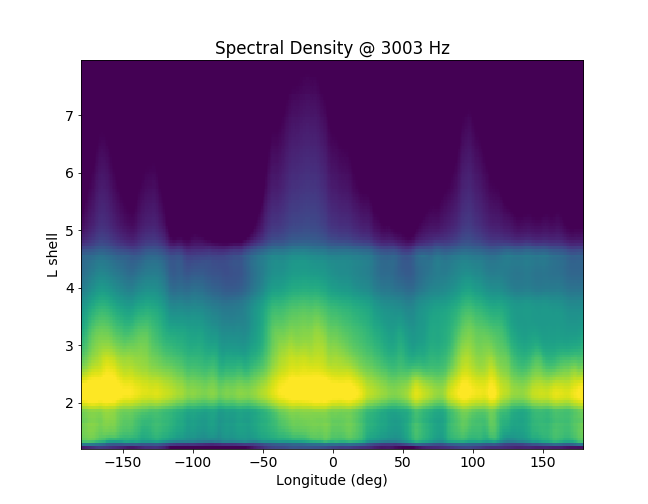

In [656]:
# fig, ax = plt.subplots(1,1)
print pwr_maps.keys()
print counts.keys()
print np.shape(pwr_maps[0])

fig, ax = plt.subplots(1,1)

f_ind = 10



ax.pcolorfast(gridlons, gridLs, pwr_maps[0][:,f_ind,:].T, vmin=-23, vmax=-18)
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('L shell')
ax.set_title('Spectral Density @ %d Hz'%gridFs[f_ind])

(360, 100, 136)


<IPython.core.display.Javascript object>


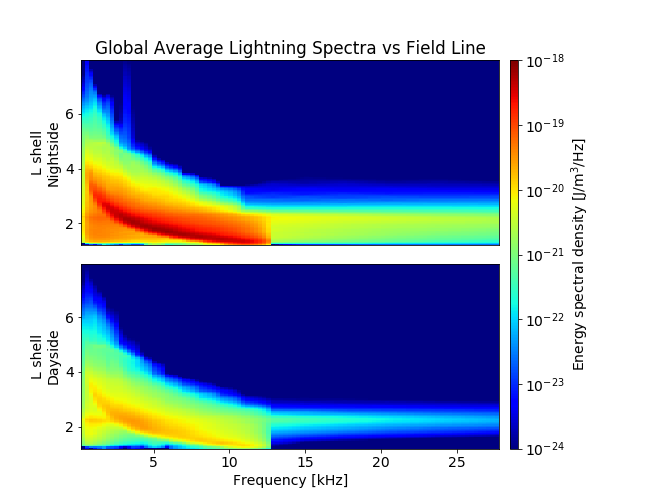

In [753]:

# Plot spectral density vs L-shell over the US:
dens_vs_L = dict()

lonlims = [-180, 180]  # ~ approximately over the US

left_ind  = bisect.bisect_left(gridlons - 180, lonlims[0])
right_ind = bisect.bisect_left(gridlons - 180, lonlims[1])

print np.shape(pwr_maps_linear[0])
# print np.shape(gridlons), np.shape(gridFs), np.shape(gridLs)
for k in pwr_maps.keys():
    dens_vs_L[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind,:,:], axis=0)/(right_ind - left_ind)
    dens_vs_L[k] = np.log10(dens_vs_L[k])
    dens_vs_L[k][np.isinf(dens_vs_L[k])] = -100

    
clims = [-24, -18]
    
fig = plt.figure()
gs = gridspec.GridSpec(2,2, width_ratios=[1,0.02])
gs.update(wspace=0.05, hspace=0.1) # set the spacing between axes.
ax = []
ax.append(plt.subplot(gs[0,0]))
ax.append(plt.subplot(gs[1,0]))
cax = plt.subplot(gs[0:2,1])

for ind, k in enumerate(dens_vs_L.keys()):
    p = ax[ind].pcolormesh(gridFs/1000., gridLs, dens_vs_L[k].T, vmin = clims[0], vmax=clims[1], cmap = plt.get_cmap('jet'))
#     ax[ind].set_xlabel('Frequency [hz]')
#     ax[ind].set_ylabel('L shell')
    
ax[0].set_xticks([])
ax[0].set_ylabel('L shell\nNightside')
ax[-1].set_ylabel('L shell\nDayside')
ax[-1].set_xlabel('Frequency [kHz]')

# Colorbar
cb = plt.colorbar(p, cax=cax)
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)
cb.set_label('Energy spectral density [J/m$^3$/Hz]') 

ax[0].set_title('Global Average Lightning Spectra vs Field Line')

fig.subplots_adjust(right=0.8)
fig.savefig('lightning_spectra_vs_L.png')

<IPython.core.display.Javascript object>


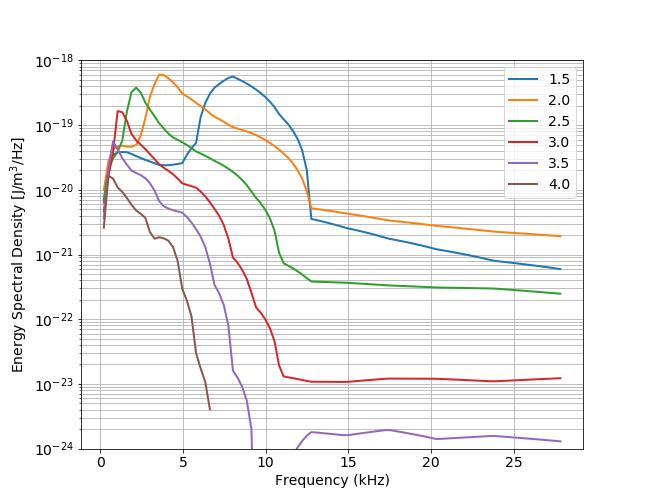

L =  1.5
L =  2.0
L =  2.5
L =  3.0
L =  3.5
L =  4.0


In [698]:
# Same data, but a line plot:

dens_vs_L_lin = dict()
for k in pwr_maps.keys():
    dens_vs_L_lin[k] = np.sum(pwr_maps_linear[k][left_ind:right_ind,:,:], axis=0)/(right_ind - left_ind)




L_inds = [6, 16, 26, 36, 46, 56]
fig, ax = plt.subplots(1,1)
for L_ind in L_inds:
    print "L = ", gridLs[L_ind]

    ax.semilogy(gridFs/1000., dens_vs_L_lin[0][:,L_ind], label = '%.1f'%gridLs[L_ind], linewidth=2)
ax.legend()
ax.grid('on', which='both')
ax.set_ylim([1e-24, 1e-18])
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Energy Spectral Density [J/m$^3$/Hz]')


<IPython.core.display.Javascript object>


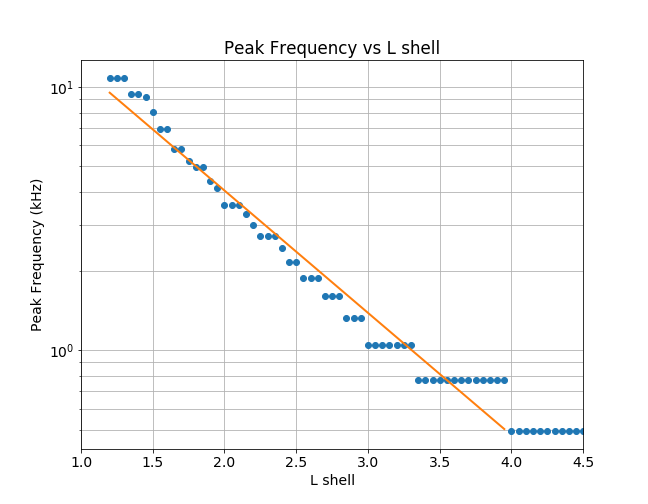

(100, 136)
[ 4.53614703 -0.46465906]


In [740]:
# Find peaks in spectra and do a fit:

# def func(x, a, b):
#     return a + b*x
# popt, pcov = scipy.optimize.curve_fit(func, gridLs, np.log10(maxF[k]))

# print popt

# fit = func(gridLs, popt[0], popt[1])

def piecewise_linear(x, x0, y0, k1, k2):
    return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])

# p , e = optimize.curve_fit(piecewise_linear, gridLs, gridFs[k])
# xd = np.linspace(0, 15, 100)
# pl.plot(x, y, "o")
# pl.plot(xd, piecewise_linear(xd, *p))

fig, ax = plt.subplots(1,1)



maxF = dict()
for k in dens_vs_L_lin.keys()[0:1]:

    print np.shape(dens_vs_L_lin[k])
    maxF[k] = gridFs[np.argmax(dens_vs_L_lin[k], axis=0)]
    p, e = scipy.optimize.curve_fit(func, gridLs[gridLs < 4], np.log10(maxF[k][gridLs < 4]))
#     p , e = scipy.optimize.curve_fit(piecewise_linear, gridLs, np.log10(gridFs[k]))
    print p
    ax.semilogy(gridLs, (maxF[k])/1000., 'o')    
    fit = func(gridLs[gridLs < 4], *p)
    ax.semilogy(gridLs[gridLs < 4], pow(10,fit)/1000., linewidth=2)
    ax.grid('on', which='both')
    ax.set_xlim([1,4.5])
    ax.set_xlabel("L shell")
    ax.set_ylabel('Peak Frequency (kHz)')
    ax.set_title('Peak Frequency vs L shell')


<IPython.core.display.Javascript object>


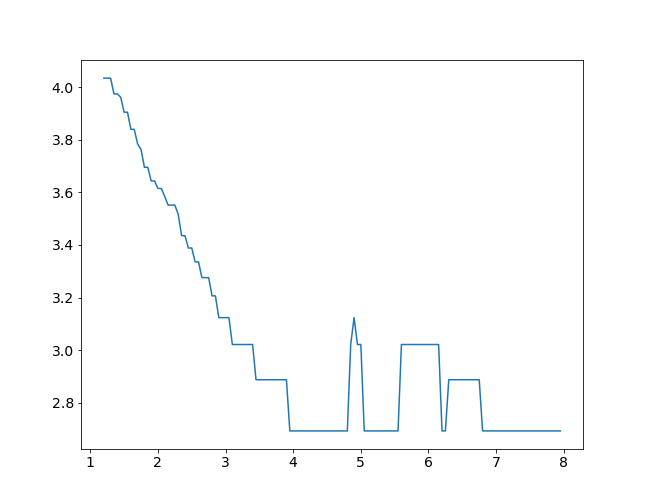

In [713]:
ax.plot(gridLs, np.log10(maxF[12]))

In [750]:
# Map peak frequency to a peak energy (estimate which energies should come down at which field line)


# The problem here is that the resonance is dependant on:
#  -- incident angle (phi)
#  -- mu (property of medium, but determined through raytracer)
#  vres = (Wh/gamma - w / Kz) 
#  Kz = Kmag * cos(phi)
#  gamma = relativistic factor, sqrt(1 - v^2/c^2) (which makes this equation implicit)



# Constants
Hz2Rad = 2.*np.pi
D2R = np.pi/180.
R2D = 180./np.pi
H_IONO_BOTTOM = 1e5
H_IONO_TOP = 1e6
R_E = 6371e3
C = 2.997956376932163e8
Q_EL = 1.602e-19
M_EL = 9.1e-31
E_EL = 5.105396765648739E5 
MU0  = np.pi*4e-7
EPS0 = 8.854E-12
B0   = 3.12e-5

# Assuming equator (there's the slat term which changes with latitude)
whvec = (Q_EL*B0/M_EL)/pow(gridLs, 3.)

epsm = (1./gridLs)*(1. + H_IONO_BOTTOM/R_E)
alpha_eq = np.arcsin(np.sqrt(pow(epsm, 3.)/np.sqrt(1 + 3.*(1. - epsm))  ))

MRES = 0
w = fit*Hz2Rad

psi = 0 # Incident angle
spsi = np.sin(psi);
cpsi = np.cos(psi);
spsi_sq = pow(spsi,2);
cpsi_sq = pow(cpsi,2);
n_x = mu*np.abs(spsi);
n_z = mu*cpsi;
mu_sq = mu*mu;
w = 2.0*PI*f;
k = w*mu/C;
kx = w*n_x/C;
kz = w*n_z/C;
Y = wh / w ;



t1 = w*w*kz*kz
t2 = pow((mres*wh),2)-w*w;
t3 = kz*kz + pow((mres*wh),2)/(pow(C*cos(alpha_lc),2));
if (mres==0):
    direction = -np.sign(kz)
else:
    direction = np.sign(kz) * np.sign(mres)

print whvec
print alpha_eq

NameError: name 'kz' is not defined

In [752]:
print longrid

[-180.   -179.75 -179.5  ...,  179.25  179.5   179.75]
